In [6]:
import numpy as np 
import pandas as pd 
import os
import re
import time
import shutil


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/modified-dataset/modified_dataset.csv
/kaggle/input/dataset-v2/another_data.csv
/kaggle/input/ready-for-tuning/ready_for_tuning.csv
/kaggle/input/phishing-dataset/combined_data.csv


In [81]:
# data = pd.read_csv("/kaggle/input/phishing-dataset/combined_data.csv",dtype={6: str})

In [82]:
# data['date']

In [83]:
# data['date'] = pd.to_datetime(data['date'], format='%a, %d %b %Y %H:%M:%S %z', errors='coerce')

In [84]:
# data['date_extracted'] = data['date'].astype('str').str[:11]

In [85]:
# data = data[data['date_extracted'] != 'NaT'] 

In [86]:
# pd.to_datetime(data['date_extracted'],errors='coerce')

In [87]:
# data.dtypes

In [4]:
# data['text'] = data['subject']+" " + data['body']

# cols_to_keep = ['text','label']
# data = data[cols_to_keep]

In [5]:
# data.isna().sum()

In [6]:
# data.dropna(inplace=True)

In [7]:
# # data_subset = data.sample(n=3000)

# data_subset = data

In [8]:
# data_subset.shape

### TEXT PREPROCESSING

# ENGLISH ONLY

In [9]:
# !pip install langdetect

In [10]:

# import logging
# from langdetect import detect, LangDetectException

# def is_english(text):
#     try:
#         if len(text.strip()) == 0:
#             raise ValueError("Text is empty or too short to detect language")
        

#         return detect(text) == 'en'
#     except LangDetectException:
#         print("Error: Unable to detect language for following text.")
#         print(text)
#         return False 
#     except ValueError as e:
#         print(f"Error: {e}")
#         return False

# data_subset['is_english'] = data_subset['text'].apply(is_english)
# print('done!')

In [2]:
df = pd.read_csv('/kaggle/input/modified-dataset/modified_dataset.csv')
# df = pd.read_csv('/kaggle/input/dataset-v2/another_data.csv')

In [3]:
map_ = {"Safe Email":0, "Phishing Email":1}
df['label'] = df['Email Type'].map(map_)

In [4]:
df = df[df['is_english']==True]
df


,text,label,is_english
0,"Never agree to be a loser Buck up, your troubl...",1,True
1,Befriend Jenna Jameson \nUpgrade your sex and ...,1,True
2,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...,1,True
3,Re: svn commit: r619753 - in /spamassassin/tru...,0,True
4,SpecialPricesPharmMoreinfo \nWelcomeFastShippi...,1,True
...,...,...,...
144681,Job: just for you. \n\n\n\nWhile we may ...,1,True
144682,the reply for your request for a job place [le...,1,True
144683,"Re: [R] Me again, about the horrible documenta...",0,True
144684,"Re: [R] RODBC problem Hello,\n\nas I wrote I c...",0,True


In [5]:
def clean_email_text(text):
    text = text.lower()

    #remove re:
    text = re.sub(r're:','',text,flags=re.IGNORECASE)
    
    # htmltags
    text = re.sub(r'<.*?>', '', text, flags=re.IGNORECASE)
    #url
    text = re.sub(r'http[s]?://\S+|www\.\S+|/[\w/.-]+', '<link>', text, flags=re.IGNORECASE)
    
    #email
    text = text.replace('[@]', '@').replace('[dot]', '.',)
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '<email>', text, flags=re.IGNORECASE)
    
    #signoff
    # text = re.sub(r'\b(best regards|regards|sincerely|thanks|thank you|kind regards|warm regards|best wishes|yours truly|yours sincerely|with appreciation|with best wishes|cheers|all the best|take care|thanks in advance|many thanks|looking forward to hearing from you|best|warmly|thanks again|gratefully|respectfully|have a great day|until next time|peace)[\s\S]*$', '', text, flags=re.IGNORECASE)
    
    #removing everything but alphanumeric..
    # text = re.sub(r'[^a-zA-Z0-9\s.,]|<link>|<email>', '', text)
    # text = re.sub(r'(?!(<link>|<email>))[^a-zA-Z0-9\s.,]', '', text, flags=re.IGNORECASE)

    text = re.sub('<link>','linkplaceholer',text, flags=re.IGNORECASE)
    text = re.sub('<email>','emailplaceholer',text, flags=re.IGNORECASE)
    
    text = re.sub(r'[^a-zA-Z0-9\s.,]', '', text, flags=re.IGNORECASE)
    
    text = re.sub('linkplaceholer','<link>',text, flags=re.IGNORECASE)
    text = re.sub('emailplaceholer','<email>',text, flags=re.IGNORECASE)


    
    #removing whitespaces
    text = re.sub(r'\s+', ' ', text, flags=re.IGNORECASE).strip()
    

    return text

In [6]:
df['processed_text'] = df['Email Text'].apply(clean_email_text)

In [7]:
df.head()

,Email Text,Email Type,label,processed_text
0,"Dear Jordan, your subscription has been succes...",Safe Email,0,"dear jordan, your subscription has been succes..."
1,"Dear Casey, thank you for your purchase. Your ...",Safe Email,0,"dear casey, thank you for your purchase. your ..."
2,Congratulations! You've won a $3000 gift card....,Phishing Email,1,congratulations youve won a 3000 gift card. cl...
3,You have a new secure message from your bank. ...,Phishing Email,1,you have a new secure message from your bank. ...
4,Your package delivery is pending. Please provi...,Phishing Email,1,your package delivery is pending. please provi...


In [12]:
# df = df.drop_duplicates(subset='text')

In [13]:
# df = df.sample(3000)

## FINETUNING

In [8]:
!pip install transformers torch evaluate peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 11.6 MB/s eta 0:00:00


In [6]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import numpy as np
import evaluate

from peft import PeftModel, PeftConfig, LoraConfig, get_peft_model


ModuleNotFoundError: No module named 'evaluate'

In [ ]:
model_path = 'distilbert-base-uncased'


id2label_={0: "SAFE", 1: "PHISHING"}
label2id_={"SAFE": 0, "PHISHING":1}

model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2,id2label=id2label_,label2id=label2id_)
tokenizer = AutoTokenizer.from_pretrained(model_path)

## custom class

In [11]:
class PhishingDataset(Dataset):

    def __init__(self,texts,lables,tokenizer,max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length


    def __len__(self):
        return len(self.texts)

    def __getitem__(self,idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels':  torch.tensor(label) 
        }


## dataset creations

In [12]:
texts = df['processed_text'].tolist()
labels = df['label'].tolist()



#spliting train 80% test 10% val 10%
train_texts, temp_texts, train_labels, temp_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

#creating datasetclass
train_dataset = PhishingDataset(train_texts, train_labels, tokenizer, max_length=256)
val_dataset = PhishingDataset(val_texts, val_labels, tokenizer, max_length=256)
test_dataset = PhishingDataset(test_texts, test_labels, tokenizer, max_length=256)

#creating batches = 32
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=32)
# test_dataloader = DataLoader(test_dataset, batch_size=32)


In [13]:
accuracy = evaluate.load("accuracy")
auc_score = evaluate.load("roc_auc")
f1 = evaluate.load('f1')
precision = evaluate.load('precision')
recall = evaluate.load('recall')


def compute_softmax(logits):
    e_x = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    softmax_predictions = e_x / e_x.sum(axis=1, keepdims=True)
    return softmax_predictions

def compute_metrics(pred):
    logits, labels = pred

    probabilities = compute_softmax(logits)
    positive_class_probs = probabilities[: , 1]
    auc_ = np.round(auc_score.compute(prediction_scores=positive_class_probs, references=labels)['roc_auc'], 3)

    
    predictions = np.argmax(probabilities, axis=1)
    accuracy_ = np.round(accuracy.compute(predictions=predictions, references=labels)['accuracy'], 3)
    f1_ = np.round(f1.compute(predictions=predictions, references=labels)['f1'], 3)
    precision_ = np.round(precision.compute(predictions=predictions, references=labels)['precision'], 3)
    recall_ = np.round(recall.compute(predictions=predictions, references=labels)['recall'], 3)

    return {
        'accuracy': accuracy_,
        'f1': f1_,
        'auc': auc_,
        'precision': precision_,
        'recall': recall_
    }

In [14]:
# ## Freezing all but pooler layers params

# #freezing
# for name, params in model.base_model.named_parameters():
#     params.requires_grade = False

# #unfreezing
# for name, params in model.base_model.named_parameters():
#     if "pooler" in name:
#         params.requires_grade = True

In [15]:
# import torch_xla.core.xla_model as xm
batch_size = 32
epochs = 5
lr = 2e-5

# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"

# If using CPU, switch to TPU device
# if device == "cpu":
#     device = xm.xla_device()  

if device == 'cpu':
    raise ValueError('CPU is getting selected not recommended')

model.to(device)
print(f"Model is running on: {device}")


training_args = TrainingArguments(
    output_dir='./results',
    run_name='subset_train',
    num_train_epochs = epochs,
    per_device_train_batch_size=batch_size,  
    per_device_eval_batch_size=8,
    learning_rate= lr,               
    logging_strategy= "epoch",
    eval_strategy="epoch",  
    save_strategy= "epoch",
    # gradient_accumulation_steps=4,
    load_best_model_at_end = True,
    
)

trainer = Trainer(
    model = model,
    args = training_args,
    tokenizer = tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
    
)

Model is running on: cuda


In [16]:
import time

t1 = time.time()
trainer.train()
t2 = time.time()

time_taken_minutes = round((t2 - t1) / 60, 2)
time_taken_hours = round(time_taken_minutes / 60, 2)

print(f"Tuning Time: {time_taken_hours} hours")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1,Auc,Precision,Recall
1,0.700700,0.691477,0.515000,0.598000,0.509000,0.511000,0.720000
2,0.694200,0.690675,0.520000,0.368000,0.553000,0.538000,0.280000
3,0.689700,0.690084,0.550000,0.591000,0.534000,0.542000,0.650000
4,0.692000,0.694186,0.535000,0.601000,0.531000,0.526000,0.700000
5,0.689800,0.691989,0.525000,0.585000,0.540000,0.519000,0.670000


Tuning Time: 0.06 hours


In [27]:
# data_subset['label'].value_counts()

In [28]:
# model.save_pretrained('./saved_model')
# tokenizer.save_pretrained('./saved_model')

In [29]:
# from transformers import pipeline

# phishing_pipe = pipeline('text-classification', model=model, tokenizer=tokenizer)

# def predict_phishing(text):
#     result = phishing_pipe(text)
#     # print(result)
#     return result[0]['label'], result[0]['score']

In [30]:
# pred = trainer.predict(test_dataset)

# compute_metrics((pred.predictions,pred.label_ids))


In [31]:
# for i in len(df):
#     result = predict_phishing(df.iloc[i]['text'])
#     if res    

In [32]:
 # predict_phishing(df.iloc[4]['text'])

In [33]:
import shutil

# Path to the folder where the model is saved
model_folder = './saved_model'

# Create a zip file for the folder
shutil.make_archive('saved_model', 'zip', model_folder)



# OTHER WAY

In [17]:
pip install tensorflow tensorflow-addons

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.10.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.
ydata-profiling 4.10.0 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np 
import pandas as pd 
import os
import re
import math
import time
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# df = pd.read_csv('/kaggle/input/modified-dataset/modified_dataset.csv')
# df = pd.read_csv('/kaggle/input/ready-for-tuning/ready_for_tuning.csv')
# df = pd.read_csv('/kaggle/input/dataset-v2/another_data.csv')

In [6]:
# df[df['is_english'] == True]
# df.drop(columns = ['is_english'],inplace=True)
# df.drop_duplicates(inplace=True)

In [7]:
# (df['label'].value_counts()/df.shape[0]) * 100

In [8]:
# df['length'] = df['text'].str.len()
# df

In [9]:
# plt.hist(df['length'])
# plt.title('Word length Histogram')
# plt.show()

In [10]:
# sns.histplot(df['length'],kde=True)
# plt.title('Word length Histogram (KDE)')
# plt.show()

In [11]:
# df['length'].min(), df['length'].median(), df['length'].max()

In [106]:
def clean_email_text(text):
    text = text.lower()

    #remove re:
    text = re.sub(r're:','',text,flags=re.IGNORECASE)
    
    # htmltags
    text = re.sub(r'<.*?>', '', text, flags=re.IGNORECASE)
    #url
    text = re.sub(r'http[s]?://\S+|www\.\S+|/[\w/.-]+', '<link>', text, flags=re.IGNORECASE)
    
    #email
    text = text.replace('[@]', '@').replace('[dot]', '.',)
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '<email>', text, flags=re.IGNORECASE)
    
    # signoff
    text = re.sub(r'\b(best regards|regards|sincerely|thank you|kind regards|warm regards|best wishes|yours truly|yours sincerely|with appreciation|respectfully|have a great day|until next time|peace),[\s\S]*$', '', text, flags=re.IGNORECASE)
    
    #removing everything but alphanumeric..
    # text = re.sub(r'[^a-zA-Z0-9\s.,]|<link>|<email>', '', text)
    # text = re.sub(r'(?!(<link>|<email>))[^a-zA-Z0-9\s.,]', '', text, flags=re.IGNORECASE)

    text = re.sub('<link>','linkplaceholder',text, flags=re.IGNORECASE)
    text = re.sub('<email>','emailplaceholder',text, flags=re.IGNORECASE)
    
    text = re.sub(r'[^a-zA-Z0-9\s.,]', '', text, flags=re.IGNORECASE)
    
    text = re.sub('linkplaceholder','<link>',text, flags=re.IGNORECASE)
    text = re.sub('emailplaceholder','<email>',text, flags=re.IGNORECASE)


    
    #removing whitespaces
    text = re.sub(r'\s+', ' ', text, flags=re.IGNORECASE).strip()
    

    return text

In [6]:
# df['text'] = df['text'].apply(clean_email_text)
df['processed_text'] = df['Email Text'].apply(clean_email_text)

In [7]:
df['after_len'] = df['processed_text'].str.len()

In [8]:
# df.reset_index(inplace=True,drop=True)
df

,Email Text,Email Type,processed_text,after_len
0,"Dear Jordan, your subscription has been succes...",Safe Email,"dear jordan, your subscription has been succes...",99
1,"Dear Casey, thank you for your purchase. Your ...",Safe Email,"dear casey, thank you for your purchase. your ...",73
2,Congratulations! You've won a $3000 gift card....,Phishing Email,congratulations youve won a 3000 gift card. cl...,75
3,You have a new secure message from your bank. ...,Phishing Email,you have a new secure message from your bank. ...,68
4,Your package delivery is pending. Please provi...,Phishing Email,your package delivery is pending. please provi...,95
...,...,...,...,...
1995,Your payment has been declined. Update your bi...,Phishing Email,your payment has been declined. update your bi...,94
1996,"Hi Taylor, it was great meeting you at the con...",Safe Email,"hi taylor, it was great meeting you at the con...",90
1997,Your subscription is about to expire. Renew no...,Phishing Email,your subscription is about to expire. renew no...,82
1998,"Hi John, just a reminder about the project dea...",Safe Email,"hi john, just a reminder about the project dea...",100


In [9]:
df[df['Email Text'].str.contains('Your payment has been declined. Update')]

,Email Text,Email Type,processed_text,after_len
48,Your payment has been declined. Update your bi...,Phishing Email,your payment has been declined. update your bi...,94
58,Your payment has been declined. Update your bi...,Phishing Email,your payment has been declined. update your bi...,94
63,Your payment has been declined. Update your bi...,Phishing Email,your payment has been declined. update your bi...,94
70,Your payment has been declined. Update your bi...,Phishing Email,your payment has been declined. update your bi...,94
98,Your payment has been declined. Update your bi...,Phishing Email,your payment has been declined. update your bi...,94
...,...,...,...,...
1960,Your payment has been declined. Update your bi...,Phishing Email,your payment has been declined. update your bi...,94
1974,Your payment has been declined. Update your bi...,Phishing Email,your payment has been declined. update your bi...,94
1993,Your payment has been declined. Update your bi...,Phishing Email,your payment has been declined. update your bi...,94
1995,Your payment has been declined. Update your bi...,Phishing Email,your payment has been declined. update your bi...,94


In [10]:
df['after_len'].min(), df['after_len'].median(), df['after_len'].max()

(68, 87.0, 103)

In [18]:
# df.iloc[136827]['text']

In [29]:
df = df[df['processed_text'] != ""]
df.drop_duplicates(inplace=True)
df.drop_duplicates(subset=['processed_text'],inplace=True)
df.reset_index(inplace = True)

In [20]:
# (df['label'].value_counts()/df.shape[0])*100

In [11]:
map_ = {"Safe Email":0, "Phishing Email":1}
df['label'] = df['Email Type'].map(map_)

# SETTING UP FOR FINE TUNING

In [7]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from tensorflow.keras.metrics import AUC
from tensorflow.keras import mixed_precision



# Reset policy to float32
policy = mixed_precision.Policy('float32')
mixed_precision.set_global_policy(policy)

# Verify the policy
print("Current policy:", mixed_precision.global_policy())


df = pd.read_csv("/kaggle/input/ready-for-tuning/ready_for_tuning.csv",dtype={6: str})

Current policy: <FloatDTypePolicy "float32">


In [8]:
# MODEL_NAME = 'bert-base-uncased'
MODEL_NAME = 'distilbert-base-uncased'
BATCH_SIZE = 8
EPOCHS_PER_BATCH = 3
MAX_LENGTH = 512
TOTAL_SAMPLES = len(df)
BATCH_SAMPLES = 5000
SAVE_PATH = "/kaggle/working/bert_phishing/"

os.makedirs(SAVE_PATH, exist_ok=True)

In [22]:
df.drop_duplicates(inplace=True)

In [29]:
texts = df['text']
# texts = df['processed_text']

labels = df['label'].values.astype(np.float32)  # Binary labels (0/1)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

id2label = {0: 'Safe',1: 'Phishing'}
label2id = {'Safe': 0,'Phishing': 1}


model = TFAutoModelForSequenceClassification.from_pretrained(MODEL_NAME, 
                                                              num_labels=1)
                                                              # id2label=id2label, 
                                                              # label2id=label2id)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that y

In [12]:
model.config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.45.1",
  "vocab_size": 30522
}

In [13]:
model.classifier.get_config()

{'name': 'classifier',
 'trainable': True,
 'dtype': 'float32',
 'units': 1,
 'activation': 'linear',
 'use_bias': True,
 'kernel_initializer': {'module': 'keras.initializers',
  'class_name': 'TruncatedNormal',
  'config': {'mean': 0.0, 'stddev': 0.02, 'seed': None},
  'registered_name': None},
 'bias_initializer': {'module': 'keras.initializers',
  'class_name': 'Zeros',
  'config': {},
  'registered_name': None},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [35]:
# model.bert

In [40]:
optimizer = tf.optimizers.Adam(learning_rate=2e-5,weight_decay=0.01)
# optimizer = mixed_precision.LossScaleOptimizer(optimizer)


loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[
       'accuracy'
    ]
)

In [15]:
model.layers[-2].get_config()

{'name': 'classifier',
 'trainable': True,
 'dtype': 'float32',
 'units': 1,
 'activation': 'linear',
 'use_bias': True,
 'kernel_initializer': {'module': 'keras.initializers',
  'class_name': 'TruncatedNormal',
  'config': {'mean': 0.0, 'stddev': 0.02, 'seed': None},
  'registered_name': None},
 'bias_initializer': {'module': 'keras.initializers',
  'class_name': 'Zeros',
  'config': {},
  'registered_name': None},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [16]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66954241 (255.41 MB)
Trainable params: 66954241 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
def create_stratified_batches(texts, labels, batch_size, seed = 42):

    np.random.seed(seed)
    
    # Create a list of indices based on the labels to maintain balance in batches
    indices_0 = np.where(labels == 0)[0]
    indices_1 = np.where(labels == 1)[0]

    # Shuffle the indices
    np.random.shuffle(indices_0)
    np.random.shuffle(indices_1)

    # Combine indices into balanced batches
    batch_indices = []
    for i in range(0, len(indices_0), batch_size // 2):
        batch_0 = indices_0[i:i + batch_size // 2]
        batch_1 = indices_1[i:i + batch_size // 2]

        # Combine and shuffle batches to maintain randomness
        combined_batch = np.concatenate((batch_0, batch_1))
        np.random.shuffle(combined_batch)
        batch_indices.append(combined_batch)

    return batch_indices

129386

In [31]:
# First split (80% train, 20% temp)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42
)

# Second split (50% of the 20% for test and 50% for validation, i.e., 10% each)
test_texts, val_texts, test_labels, val_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# train_texts, test_texts, train_labels, test_labels = train_test_split(
#     texts, labels, test_size=0.2, stratify=labels, random_state=42
# )


In [32]:
train_batches = create_stratified_batches(train_texts, train_labels, BATCH_SAMPLES)
# val_batches = create_stratified_batches(val_texts, val_labels, BATCH_SAMPLES)
# test_batches = create_stratified_batches(test_texts, test_labels, BATCH_SAMPLES)

# len(train_batches)

In [33]:
def preprocess_batch(texts_batch, labels_batch):
    """Tokenize and format batch for DistilBERT"""
    encodings = tokenizer(
        texts_batch.tolist(),
        truncation=True,
        padding='max_length',
        max_length=MAX_LENGTH,
        return_tensors='tf'
    )
    return {'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask']}, labels_batch

In [34]:
# Check if GPU is available
device_name = "/device:GPU:0"

if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")
    raise ValueError("GPU NOT AVAILABLE")


# List all available GPUs
physical_devices = tf.config.list_physical_devices('GPU')


# Set the first GPU as visible
if physical_devices:
    # tf.config.experimental.set_memory_growth(device, True)
    # tf.config.experimental.get_memory_usage(physical_devices[0])

    tf.config.set_visible_devices(physical_devices[0], 'GPU')  # Use first GPU
else:
    print("No GPU detected.")

physical_devices

GPU is available


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [35]:
!nvidia-smi

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Sat Feb 15 16:32:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P0             32W /  250W |   15773MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [62]:
# #clears the memory

# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()

In [63]:
# with tf.device('/GPU:0'):
#         # Preprocess batch
#         X, y = preprocess_batch(train_texts, train_labels)
    
#         # Train on current batch
#         history = model.fit(
#             X,
#             y,
#             epochs=EPOCHS_PER_BATCH, 
#             batch_size=BATCH_SIZE, 
#             verbose=1
#         )

In [38]:
len(val_labels)

12939

In [41]:
# Training loop with checkpointing
best_val_auc = 0.0  # Track best AUC for saving the best model
for i, batch_indices in enumerate(tqdm(train_batches)):
    # Get current batch
    a = batch_indices
    
    batch_texts = train_texts.iloc[batch_indices]
    batch_labels = train_labels[batch_indices]

    with tf.device('/GPU:0'):
        # Preprocess batch
        X, y = preprocess_batch(batch_texts, batch_labels)
    
        # Train on current batch
        history = model.fit(
            X,
            y,
            epochs=EPOCHS_PER_BATCH, 
            batch_size=BATCH_SIZE, 
            verbose=1
        )
      
    
    # Save model weights after each batch
    model.save_weights(f"{SAVE_PATH}batch_{i+1}_weights.h5")
    
    # Optional: Validate on validation set after every few batches or at the end of each epoch
    # if (i + 1) % 3 == 0:  # Evaluate every turn
        # val_accuracy = []
    #     val_loss =[]
    #     true_labels = []
    #     predicted_probs = []
        
    #     for val_batch in val_batches:
    #         val_texts_batch = val_texts.iloc[val_batch]
    #         val_labels_batch = val_labels[val_batch]
    #         X_val, y_val = preprocess_batch(val_texts_batch, val_labels_batch)
            
    #         metrics = model.evaluate(X_val, y_val, verbose=0)
    #         val_loss.append(metrics[0])  #loss
    #         val_accuracy.append(metrics[1])  # accuracy
            
    #         y_pred = model.predict(X_val, verbose=0)
    #         y_pred_probs = tf.sigmoid(y_pred.logits).numpy().flatten()
    #         true_labels.extend(val_labels_batch)
    #         predicted_probs.extend(y_pred_probs)

        
    #     avg_val_accuracy = np.mean(val_accuracy)
    #     auc = roc_auc_score(true_labels, predicted_probs)

# NEW SHIT
    
        # X_val , y_val = preprocess_batch(val_texts)
    
        
        # print('validation loss:',val_loss)
        # print('validation accuracy:',val_accuracy)
        # print('validation AUC Score :',auc)

        
    
        # if auc > best_val_auc:
        #     print('A better model has been found!')
        #     best_val_auc = auc
        #     model.save_pretrained(SAVE_PATH + "best_model")
            # tokenizer.save_pretrained(SAVE_PATH + "best_model")


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1/3
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1739637669.328725     101 service.cc:145] XLA service 0x7d132f324bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739637669.328788     101 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1739637669.505515     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 [==============================] - 212s 276ms/step - loss: 0.1822 - accuracy: 0.9222
Epoch 2/3
625/625 [==============================] - 172s 275ms/step - loss: 0.0555 - accuracy: 0.9814
Epoch 3/3
625/625 [==============================] - 172s 275ms/step - loss: 0.0239 - accuracy: 0.9942


  5%|▍         | 1/21 [09:19<3:06:20, 559.04s/it]

Epoch 1/3
625/625 [==============================] - 172s 275ms/step - loss: 0.0786 - accuracy: 0.9706
Epoch 2/3
625/625 [==============================] - 172s 275ms/step - loss: 0.0233 - accuracy: 0.9934
Epoch 3/3
625/625 [==============================] - 172s 274ms/step - loss: 0.0117 - accuracy: 0.9968


 10%|▉         | 2/21 [17:56<2:49:18, 534.64s/it]

Epoch 1/3
625/625 [==============================] - 172s 275ms/step - loss: 0.0612 - accuracy: 0.9768
Epoch 2/3
625/625 [==============================] - 172s 275ms/step - loss: 0.0174 - accuracy: 0.9942
Epoch 3/3
625/625 [==============================] - 172s 274ms/step - loss: 0.0091 - accuracy: 0.9972


 14%|█▍        | 3/21 [26:34<2:38:02, 526.79s/it]

Epoch 1/3
625/625 [==============================] - 172s 274ms/step - loss: 0.0525 - accuracy: 0.9800
Epoch 2/3
625/625 [==============================] - 171s 274ms/step - loss: 0.0194 - accuracy: 0.9950
Epoch 3/3
625/625 [==============================] - 171s 274ms/step - loss: 0.0056 - accuracy: 0.9982


 19%|█▉        | 4/21 [35:11<2:28:11, 523.00s/it]

Epoch 1/3
625/625 [==============================] - 172s 274ms/step - loss: 0.0448 - accuracy: 0.9830
Epoch 2/3
625/625 [==============================] - 172s 275ms/step - loss: 0.0070 - accuracy: 0.9980
Epoch 3/3
625/625 [==============================] - 172s 275ms/step - loss: 0.0015 - accuracy: 0.9996


 24%|██▍       | 5/21 [43:49<2:19:00, 521.26s/it]

Epoch 1/3
625/625 [==============================] - 172s 275ms/step - loss: 0.0466 - accuracy: 0.9844
Epoch 2/3
625/625 [==============================] - 172s 275ms/step - loss: 0.0095 - accuracy: 0.9966
Epoch 3/3
625/625 [==============================] - 172s 275ms/step - loss: 0.0039 - accuracy: 0.9990


 29%|██▊       | 6/21 [52:28<2:10:05, 520.37s/it]

Epoch 1/3
625/625 [==============================] - 172s 275ms/step - loss: 0.0374 - accuracy: 0.9898
Epoch 2/3
625/625 [==============================] - 172s 275ms/step - loss: 0.0096 - accuracy: 0.9970
Epoch 3/3
625/625 [==============================] - 172s 275ms/step - loss: 0.0029 - accuracy: 0.9990


 33%|███▎      | 7/21 [1:01:05<2:01:13, 519.55s/it]

Epoch 1/3
625/625 [==============================] - 172s 275ms/step - loss: 0.0434 - accuracy: 0.9852
Epoch 2/3
625/625 [==============================] - 171s 274ms/step - loss: 0.0070 - accuracy: 0.9972
Epoch 3/3
625/625 [==============================] - 171s 274ms/step - loss: 0.0053 - accuracy: 0.9980


 38%|███▊      | 8/21 [1:09:43<1:52:27, 519.02s/it]

Epoch 1/3
625/625 [==============================] - 171s 274ms/step - loss: 0.0377 - accuracy: 0.9890
Epoch 2/3
625/625 [==============================] - 171s 274ms/step - loss: 0.0081 - accuracy: 0.9986
Epoch 3/3
625/625 [==============================] - 171s 274ms/step - loss: 0.0044 - accuracy: 0.9986


 43%|████▎     | 9/21 [1:18:21<1:43:41, 518.45s/it]

Epoch 1/3
625/625 [==============================] - 171s 274ms/step - loss: 0.0335 - accuracy: 0.9908
Epoch 2/3
625/625 [==============================] - 171s 274ms/step - loss: 0.0051 - accuracy: 0.9982
Epoch 3/3
625/625 [==============================] - 171s 274ms/step - loss: 0.0019 - accuracy: 0.9996


 48%|████▊     | 10/21 [1:26:57<1:34:57, 517.98s/it]

Epoch 1/3
625/625 [==============================] - 171s 274ms/step - loss: 0.0352 - accuracy: 0.9882
Epoch 2/3
625/625 [==============================] - 171s 274ms/step - loss: 0.0061 - accuracy: 0.9988
Epoch 3/3
625/625 [==============================] - 171s 274ms/step - loss: 8.3232e-04 - accuracy: 0.9996


 52%|█████▏    | 11/21 [1:35:34<1:26:16, 517.67s/it]

Epoch 1/3
625/625 [==============================] - 171s 274ms/step - loss: 0.0335 - accuracy: 0.9886
Epoch 2/3
625/625 [==============================] - 171s 274ms/step - loss: 0.0091 - accuracy: 0.9974
Epoch 3/3
625/625 [==============================] - 171s 274ms/step - loss: 8.6208e-04 - accuracy: 0.9998


 57%|█████▋    | 12/21 [1:44:12<1:17:37, 517.51s/it]

Epoch 1/3
625/625 [==============================] - 172s 274ms/step - loss: 0.0379 - accuracy: 0.9880
Epoch 2/3
625/625 [==============================] - 172s 275ms/step - loss: 0.0030 - accuracy: 0.9992
Epoch 3/3
625/625 [==============================] - 172s 275ms/step - loss: 1.3956e-04 - accuracy: 1.0000


 62%|██████▏   | 13/21 [1:52:49<1:09:00, 517.58s/it]

Epoch 1/3
625/625 [==============================] - 172s 275ms/step - loss: 0.0291 - accuracy: 0.9912
Epoch 2/3
625/625 [==============================] - 172s 274ms/step - loss: 0.0034 - accuracy: 0.9992
Epoch 3/3
625/625 [==============================] - 172s 274ms/step - loss: 3.5690e-04 - accuracy: 0.9998


 67%|██████▋   | 14/21 [2:01:27<1:00:23, 517.69s/it]

Epoch 1/3
625/625 [==============================] - 172s 275ms/step - loss: 0.0300 - accuracy: 0.9898
Epoch 2/3
625/625 [==============================] - 172s 275ms/step - loss: 0.0059 - accuracy: 0.9992
Epoch 3/3
625/625 [==============================] - 171s 274ms/step - loss: 0.0050 - accuracy: 0.9988


 71%|███████▏  | 15/21 [2:10:06<51:48, 518.06s/it]  

Epoch 1/3
625/625 [==============================] - 171s 274ms/step - loss: 0.0355 - accuracy: 0.9880
Epoch 2/3
625/625 [==============================] - 171s 274ms/step - loss: 0.0086 - accuracy: 0.9970
Epoch 3/3
625/625 [==============================] - 171s 274ms/step - loss: 0.0037 - accuracy: 0.9996


 76%|███████▌  | 16/21 [2:18:44<43:10, 518.03s/it]

Epoch 1/3
625/625 [==============================] - 172s 274ms/step - loss: 0.0286 - accuracy: 0.9920
Epoch 2/3
625/625 [==============================] - 171s 274ms/step - loss: 0.0073 - accuracy: 0.9984
Epoch 3/3
625/625 [==============================] - 171s 274ms/step - loss: 0.0027 - accuracy: 0.9992


 81%|████████  | 17/21 [2:27:21<34:31, 517.79s/it]

Epoch 1/3
625/625 [==============================] - 172s 275ms/step - loss: 0.0326 - accuracy: 0.9874
Epoch 2/3
625/625 [==============================] - 172s 275ms/step - loss: 0.0018 - accuracy: 0.9994
Epoch 3/3
625/625 [==============================] - 172s 275ms/step - loss: 3.4296e-04 - accuracy: 0.9998


 86%|████████▌ | 18/21 [2:35:59<25:53, 517.85s/it]

Epoch 1/3
625/625 [==============================] - 172s 275ms/step - loss: 0.0318 - accuracy: 0.9908
Epoch 2/3
625/625 [==============================] - 172s 275ms/step - loss: 0.0087 - accuracy: 0.9984
Epoch 3/3
625/625 [==============================] - 172s 275ms/step - loss: 0.0014 - accuracy: 0.9996


 90%|█████████ | 19/21 [2:44:37<17:15, 517.83s/it]

Epoch 1/3
625/625 [==============================] - 172s 275ms/step - loss: 0.0331 - accuracy: 0.9908
Epoch 2/3
625/625 [==============================] - 172s 275ms/step - loss: 0.0051 - accuracy: 0.9990
Epoch 3/3
625/625 [==============================] - 172s 275ms/step - loss: 0.0020 - accuracy: 0.9998


 95%|█████████▌| 20/21 [2:53:15<08:38, 518.00s/it]

Epoch 1/3
439/439 [==============================] - 136s 283ms/step - loss: 0.0267 - accuracy: 0.9900
Epoch 2/3
439/439 [==============================] - 124s 283ms/step - loss: 0.0018 - accuracy: 0.9997
Epoch 3/3
439/439 [==============================] - 124s 283ms/step - loss: 1.4405e-04 - accuracy: 1.0000


100%|██████████| 21/21 [2:59:42<00:00, 513.46s/it]


In [ ]:
# # Optional: Validate on validation set after every few batches or at the end of each epoch
#     if (i + 1) % 1 == 0:  # Evaluate every 1/2 batch size
#         val_loss, val_acc, val_auc = [], [], []
#         for val_batch in val_batches:
#             val_texts = val_texts.iloc[val_batch]
#             val_labels = val_labels[val_batch]
#             X_val, y_val = preprocess_batch(val_texts, val_labels)
#             metrics = model.evaluate(X_val, y_val, verbose=0)
#             val_loss.append(metrics[0])
#             val_acc.append(metrics[1])
#             val_auc.append(metrics[2])
        
#         avg_val_auc = np.mean(val_auc)
#         print(f"\nAfter Batch {i+1}:")
#         print(f"Val Loss: {np.mean(val_loss):.4f}")
#         print(f"Val Acc: {np.mean(val_acc):.4f}")
#         print(f"Val AUC: {avg_val_auc:.4f}\n")
        
#         # Save best model based on AUC
#         if avg_val_auc > best_val_auc:
#             best_val_auc = avg_val_auc
#             model.save_pretrained(SAVE_PATH + "best_model")
#             tokenizer.save_pretrained(SAVE_PATH + "best_model")

In [43]:
import shutil

# Path to the folder where the model is saved
model_folder = '/kaggle/working/bert_phishing'

# Create a zip file for the folder
shutil.make_archive('saved_model', 'zip', model_folder)



'/kaggle/working/saved_model.zip'

In [95]:
test_texts

20723     r trying to run simple survival program in r b...
128947    get kviagra1.79 here to save on your medicatio...
111815    svn commit samba r23343 in branches samba30<li...
33392     opensuse importing a csv file into kaddressboo...
67847     napoleonville land sale gary, per our conversa...
                                ...                        
113331    burn pounds off with anatrim seize your opport...
3914      opensuse 11.0 a2 updater question begin pgp si...
93152     adf detox foot patch detoxify your body. detox...
102143    is go batchelder ride the wave hxpn is explodi...
21803     autolearn vs salearn bayes hola, diego 2008<li...
Name: text, Length: 12939, dtype: object

In [161]:
np.unique(val_labels,return_counts=True)

(array([0., 1.], dtype=float32), array([6458, 6481]))

In [201]:
X_val , y_val = preprocess_batch(val_texts,val_labels)
y_pred = model.predict(X_val)

405/405 [==============================] - 133s 328ms/step


In [197]:
prob = tf.sigmoid(y_pred[0])

y_pred_binary = tf.cast(prob>0.1,tf.int32).numpy().astype(int).squeeze()

In [198]:
# len(y_pred_binary)

In [199]:
y_true = y_val.astype(int)

Precision: 0.9857
Recall: 0.9971
F1 Score: 0.9913
Accuracy: 0.9913
AUC: 0.9993


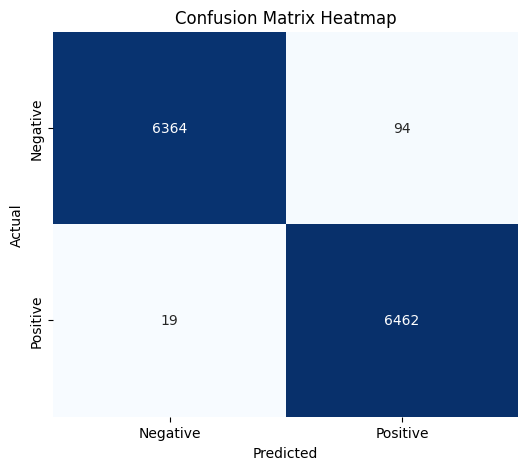

In [200]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


X_val , y_val = preprocess_batch(val_texts,val_labels)
y_pred = model.predict(X_val)

prob = tf.sigmoid(y_pred[0])
y_pred_binary = tf.cast(prob>0.1,tf.int32).numpy().astype(int).squeeze()

precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

accuracy = accuracy_score(y_true, y_pred_binary)

auc = roc_auc_score(y_true, prob.numpy())

cm = confusion_matrix(y_true, y_pred_binary)



# Print results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")



# Create a heatmap using Seaborn
plt.figure(figsize=(6, 5))  # Optional: Adjust figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')

# Show the plot
plt.show()

In [182]:
def preprocess_single_text(text):
    encodings = tokenizer(
        [text],  # Input needs to be a list
        truncation=True,
        padding='max_length',
        max_length=MAX_LENGTH,
        return_tensors='tf'
    )
    return {'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask']}

def predict_single_email(text, model):
    # Step 1: Clean the email text
    cleaned_text = clean_email_text(text)

    print(cleaned_text)

    # Preprocess the text to get tokenized inputs
    X_val = preprocess_single_text(cleaned_text) 
    
    # Step 2: Make the prediction
    y_pred = model.predict(X_val)  # Directly pass the dictionary to the model
    
    # Apply sigmoid to get probabilities
    prob = tf.sigmoid(y_pred[0])  
    
    # Convert to binary prediction (1 if prob > 0.5, else 0)
    y_pred_binary = tf.cast(prob > 0.7, tf.int32).numpy().astype(int).squeeze()
    
    return y_pred_binary, prob.numpy()


In [183]:
text ="""
Hello azfarali16,

We wanted to let you know that your GitHub password was reset.

If you did not perform this action, you can recover access by entering azfarali007.aa@gmail.com into the form at https://github.com/password_reset

To secure your account, follow the steps outlined by https://docs.github.com/articles/preventing-unauthorized-access

To see this and other security events for your account, visit https://github.com/settings/security-log

If you run into problems, please contact support by visiting https://github.com/contact

Please do not reply to this email with your password. We will never ask for your password, and we strongly discourage you from sharing it with anyone.
"""

In [184]:
prediction, probability = predict_single_email(text, model)

print(f"Prediction: {prediction}")

if prediction == 0:
    print(f"Probability: {1-probability}")
else:
    print(f"Probability: {probability}")


hello azfarali16, we wanted to let you know that your github password was reset. if you did not perform this action, you can recover access by entering <email> into the form at <link> to secure your account, follow the steps outlined by <link> to see this and other security events for your account, visit <link> if you run into problems, please contact support by visiting <link> please do not reply to this email with your password. we will never ask for your password, and we strongly discourage you from sharing it with anyone.
1/1 [==============================] - 0s 38ms/step
Prediction: 0
Probability: [[0.30835074]]


In [139]:
np.unique(test_labels,return_counts = True)

(array([0., 1.], dtype=float32), array([6458, 6481]))

Loading weights: batch_12_weights.h5
405/405 [==============================] - 133s 328ms/step
Model: batch_12_weights.h5
Precision: 0.9889
Recall: 0.9938
F1 Score: 0.9914
Accuracy: 0.9913
AUC: 0.9990


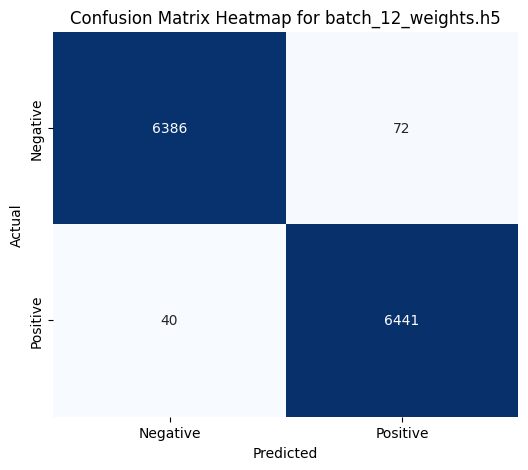

Loading weights: batch_18_weights.h5
405/405 [==============================] - 133s 328ms/step
Model: batch_18_weights.h5
Precision: 0.9753
Recall: 0.9975
F1 Score: 0.9863
Accuracy: 0.9861
AUC: 0.9989


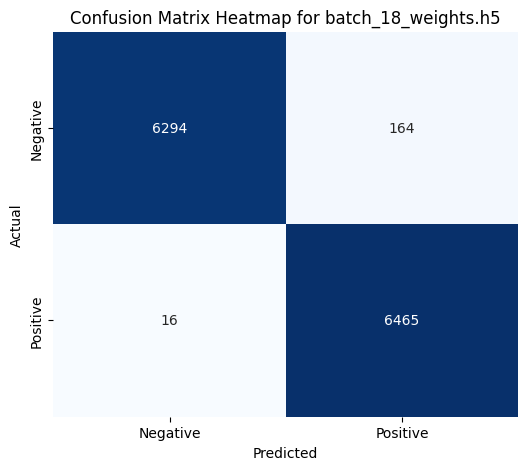

Loading weights: batch_16_weights.h5
405/405 [==============================] - 133s 328ms/step
Model: batch_16_weights.h5
Precision: 0.9923
Recall: 0.9932
F1 Score: 0.9928
Accuracy: 0.9927
AUC: 0.9994


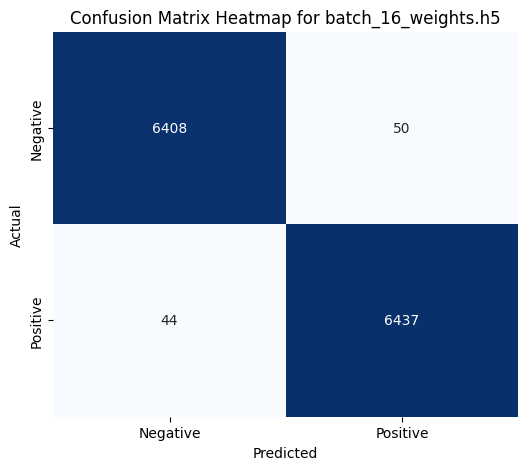

Loading weights: batch_5_weights.h5
405/405 [==============================] - 133s 328ms/step
Model: batch_5_weights.h5
Precision: 0.9817
Recall: 0.9935
F1 Score: 0.9876
Accuracy: 0.9875
AUC: 0.9990


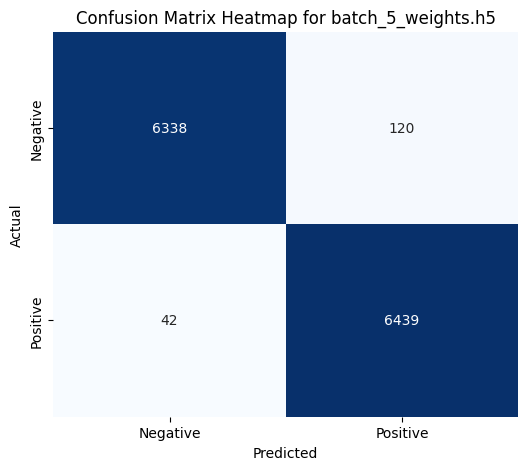

Loading weights: batch_7_weights.h5
405/405 [==============================] - 133s 328ms/step
Model: batch_7_weights.h5
Precision: 0.9895
Recall: 0.9890
F1 Score: 0.9893
Accuracy: 0.9893
AUC: 0.9991


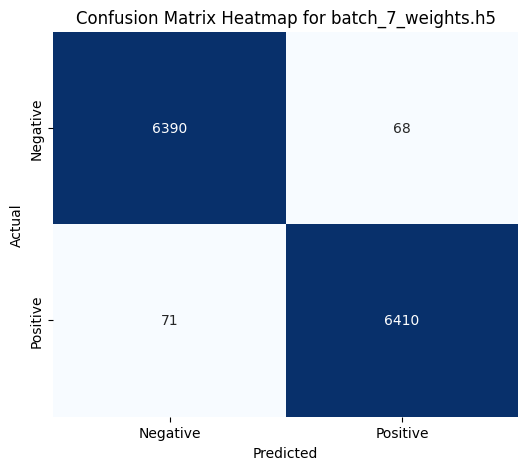

Loading weights: batch_3_weights.h5
405/405 [==============================] - 133s 328ms/step
Model: batch_3_weights.h5
Precision: 0.9607
Recall: 0.9955
F1 Score: 0.9778
Accuracy: 0.9774
AUC: 0.9980


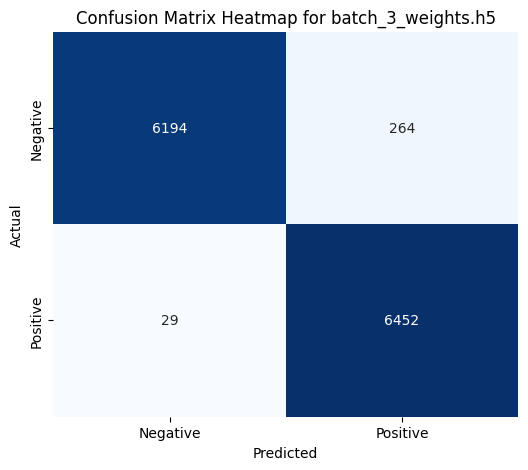

Loading weights: batch_19_weights.h5
405/405 [==============================] - 133s 328ms/step
Model: batch_19_weights.h5
Precision: 0.9906
Recall: 0.9935
F1 Score: 0.9921
Accuracy: 0.9920
AUC: 0.9993


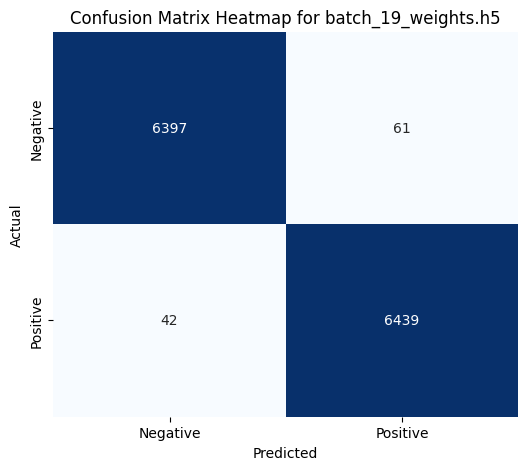

Loading weights: batch_9_weights.h5
405/405 [==============================] - 133s 328ms/step
Model: batch_9_weights.h5
Precision: 0.9809
Recall: 0.9960
F1 Score: 0.9884
Accuracy: 0.9883
AUC: 0.9991


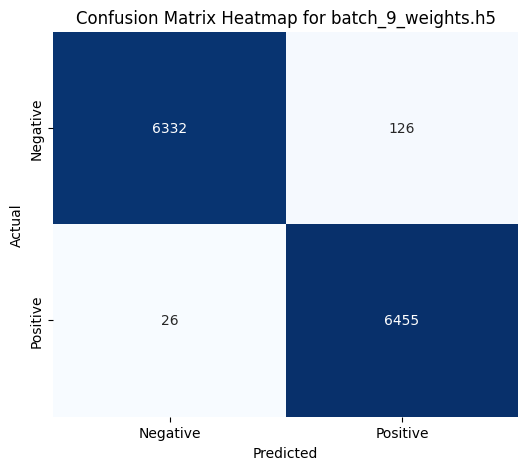

Loading weights: batch_10_weights.h5
405/405 [==============================] - 133s 328ms/step
Model: batch_10_weights.h5
Precision: 0.9875
Recall: 0.9907
F1 Score: 0.9891
Accuracy: 0.9891
AUC: 0.9987


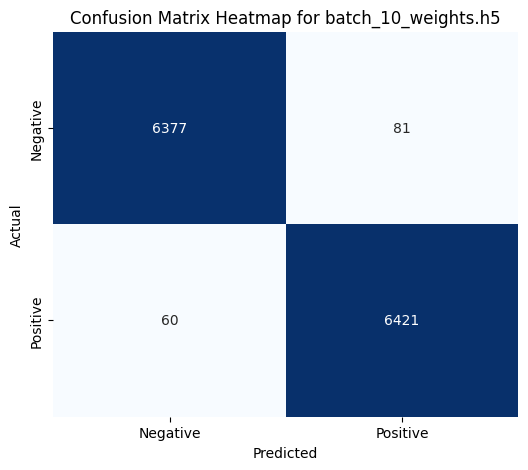

Loading weights: batch_15_weights.h5
405/405 [==============================] - 133s 328ms/step
Model: batch_15_weights.h5
Precision: 0.9894
Recall: 0.9944
F1 Score: 0.9919
Accuracy: 0.9919
AUC: 0.9991


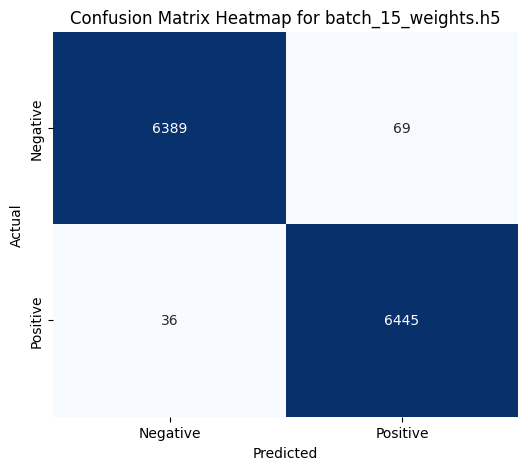

Loading weights: batch_1_weights.h5
405/405 [==============================] - 133s 328ms/step
Model: batch_1_weights.h5
Precision: 0.9856
Recall: 0.9432
F1 Score: 0.9640
Accuracy: 0.9647
AUC: 0.9965


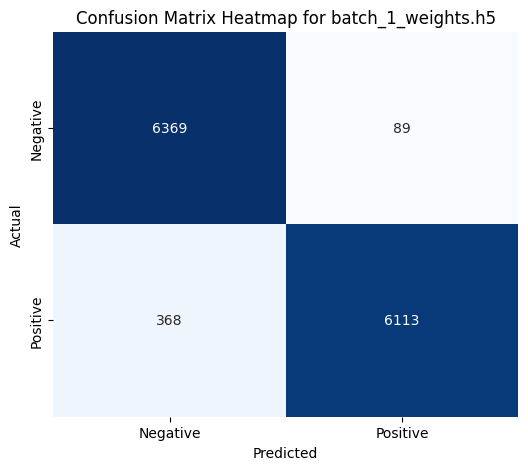

Loading weights: batch_8_weights.h5
405/405 [==============================] - 133s 328ms/step
Model: batch_8_weights.h5
Precision: 0.9821
Recall: 0.9932
F1 Score: 0.9876
Accuracy: 0.9876
AUC: 0.9991


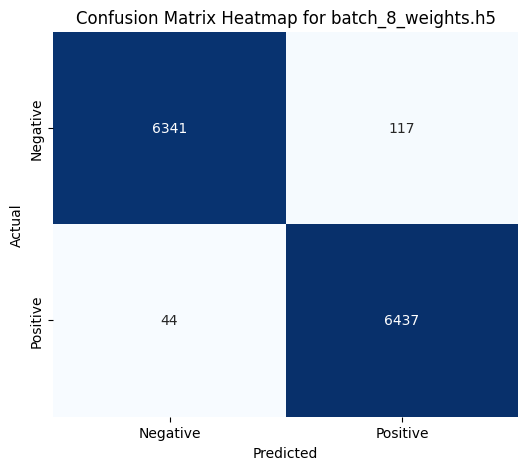

Loading weights: batch_11_weights.h5
405/405 [==============================] - 133s 328ms/step
Model: batch_11_weights.h5
Precision: 0.9909
Recall: 0.9892
F1 Score: 0.9900
Accuracy: 0.9900
AUC: 0.9991


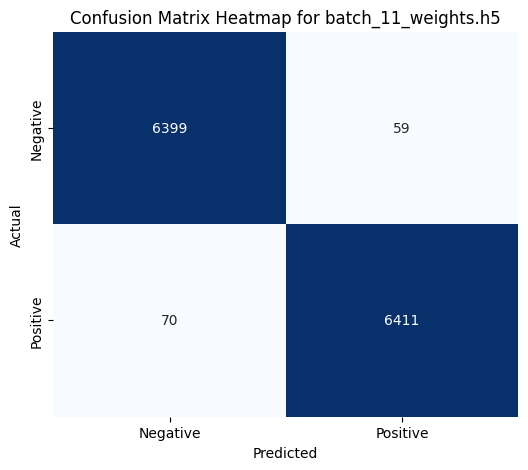

Loading weights: batch_4_weights.h5
405/405 [==============================] - 133s 328ms/step
Model: batch_4_weights.h5
Precision: 0.9836
Recall: 0.9892
F1 Score: 0.9864
Accuracy: 0.9863
AUC: 0.9991


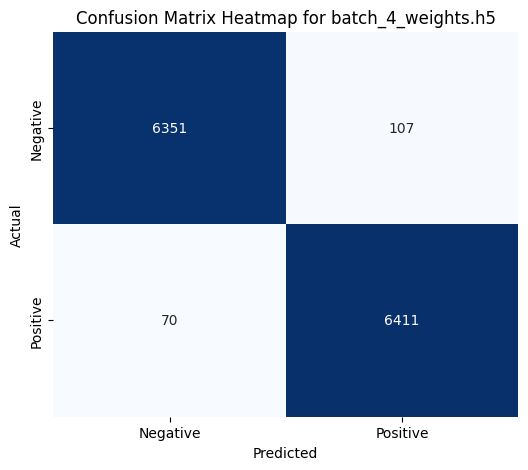

Loading weights: batch_14_weights.h5
405/405 [==============================] - 133s 328ms/step
Model: batch_14_weights.h5
Precision: 0.9917
Recall: 0.9903
F1 Score: 0.9910
Accuracy: 0.9910
AUC: 0.9992


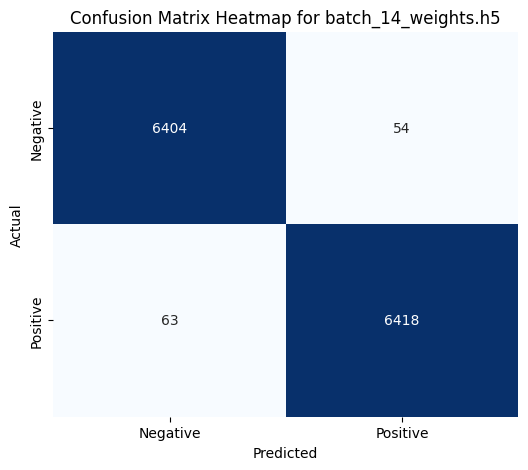

Loading weights: batch_2_weights.h5
405/405 [==============================] - 133s 328ms/step
Model: batch_2_weights.h5
Precision: 0.9849
Recall: 0.9792
F1 Score: 0.9820
Accuracy: 0.9821
AUC: 0.9982


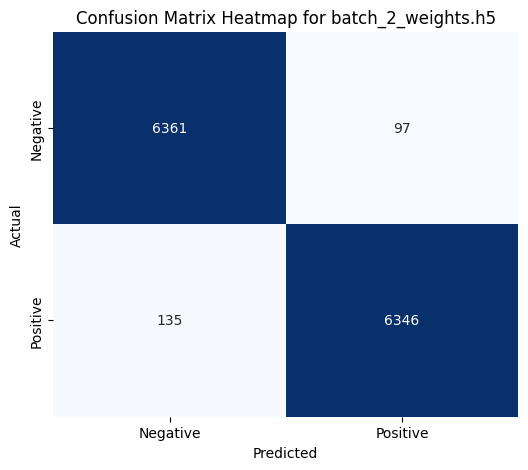

Loading weights: batch_6_weights.h5
405/405 [==============================] - 133s 328ms/step
Model: batch_6_weights.h5
Precision: 0.9869
Recall: 0.9897
F1 Score: 0.9883
Accuracy: 0.9883
AUC: 0.9991


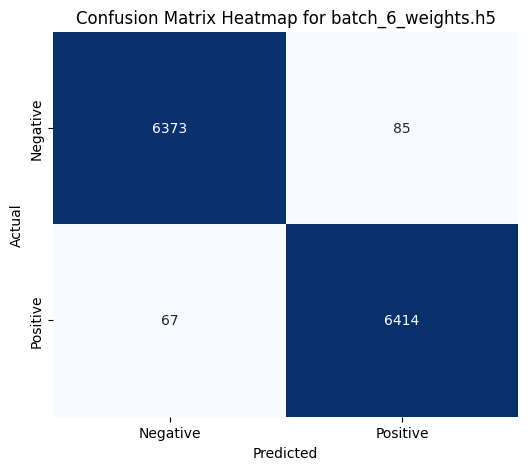

Loading weights: batch_21_weights.h5
405/405 [==============================] - 133s 328ms/step
Model: batch_21_weights.h5
Precision: 0.9896
Recall: 0.9951
F1 Score: 0.9923
Accuracy: 0.9923
AUC: 0.9993


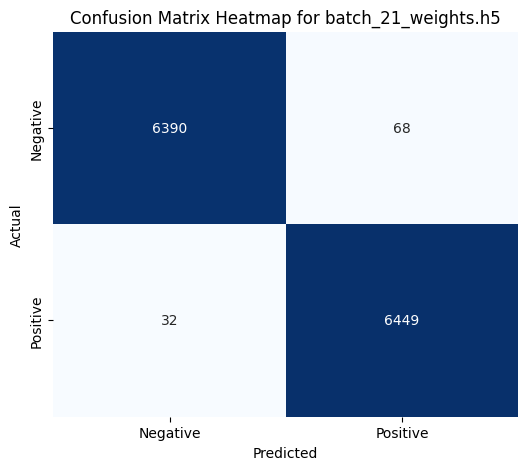

Loading weights: batch_17_weights.h5
405/405 [==============================] - 133s 328ms/step
Model: batch_17_weights.h5
Precision: 0.9935
Recall: 0.9883
F1 Score: 0.9909
Accuracy: 0.9909
AUC: 0.9994


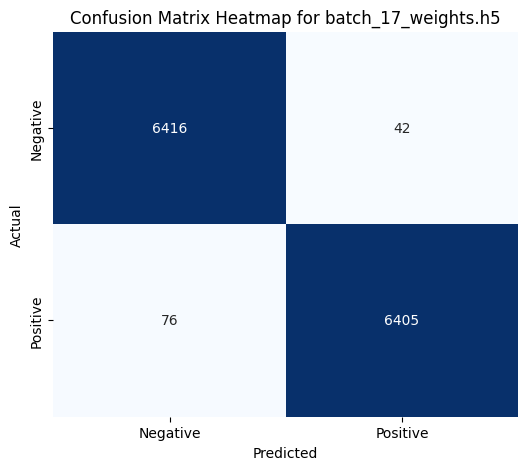

Loading weights: batch_20_weights.h5
405/405 [==============================] - 133s 328ms/step
Model: batch_20_weights.h5
Precision: 0.9927
Recall: 0.9926
F1 Score: 0.9927
Accuracy: 0.9927
AUC: 0.9992


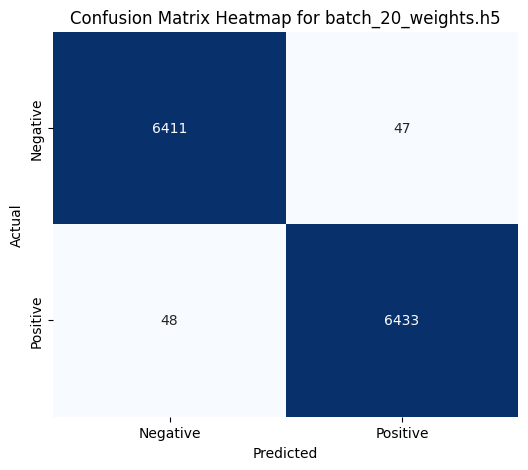

Loading weights: batch_13_weights.h5
405/405 [==============================] - 133s 328ms/step
Model: batch_13_weights.h5
Precision: 0.9903
Recall: 0.9931
F1 Score: 0.9917
Accuracy: 0.9917
AUC: 0.9993


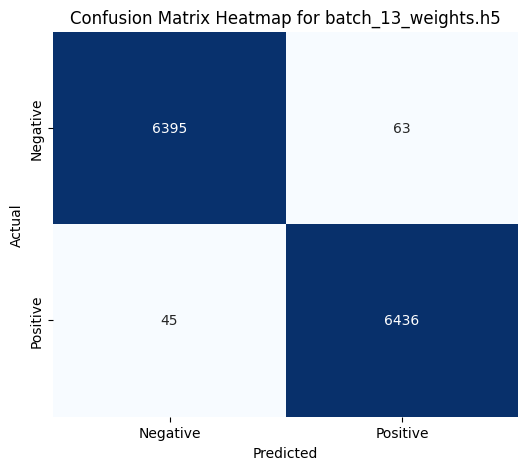

AUC List: [0.9990057174056532, 0.9989467151019951, 0.9994389942939671, 0.9989720291091729, 0.9991321799257031, 0.9979979475465101, 0.9992664552634475, 0.9991414262879286, 0.9986675800893855, 0.9991401122054419, 0.9965432462873943, 0.9991478891845229, 0.9991055279436296, 0.9990799033351365, 0.9991598712275619, 0.9982215327085405, 0.9991030550793135, 0.9992989728318942, 0.9994088779126101, 0.9991968447302594, 0.9993077293997381]
F1 List: [0.9913806372171772, 0.9862700228832952, 0.992751388032079, 0.9875766871165644, 0.9892738637240528, 0.9777979843903918, 0.9920653262460519, 0.9883631909355381, 0.9891396441500424, 0.9919199692189303, 0.9639675155720255, 0.9876486382815496, 0.9900393791985175, 0.9863835679667666, 0.9909673434725546, 0.982048901268957, 0.9882896764252697, 0.9923065086936451, 0.9908725247524752, 0.9926703186482524, 0.9916795069337443]


In [206]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize lists to store the AUC and F1 scores
auc_list = []
f1_list = []

# Directory containing model weights
weights_dir = '/kaggle/working/bert_phishing'

# Load validation data
X_val, y_val = preprocess_batch(val_texts, val_labels)

# Loop through all .h5 files in the specified directory
for weights_file in os.listdir(weights_dir):
    if weights_file.endswith('.h5'):
        # Load the model

        print('Loading weights:',weights_file)
        
        model_path = os.path.join(weights_dir, weights_file)
        model.load_weights(os.path.join(weights_dir, weights_file))

        # Run predictions on the validation set
        y_pred = model.predict(X_val)

        # Apply sigmoid and threshold to get binary predictions
        prob = tf.sigmoid(y_pred[0])
        y_pred_binary = tf.cast(prob > 0.5, tf.int32).numpy().astype(int).squeeze()

        # Compute metrics
        precision = precision_score(y_val, y_pred_binary)
        recall = recall_score(y_val, y_pred_binary)
        f1 = f1_score(y_val, y_pred_binary)
        accuracy = accuracy_score(y_val, y_pred_binary)
        auc = roc_auc_score(y_val, prob.numpy())
        cm = confusion_matrix(y_val, y_pred_binary)

        # Store AUC and F1 score for each model
        auc_list.append(auc)
        f1_list.append(f1)

        # Print results for the current model
        print(f"Model: {weights_file}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"AUC: {auc:.4f}")

        # Create a heatmap for the confusion matrix
        plt.figure(figsize=(6, 5))  # Optional: Adjust figure size
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

        # Add labels and title
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix Heatmap for {weights_file}')

        # Show the plot
        plt.show()

# Optionally, print AUC and F1 lists for comparison
print(f"AUC List: {auc_list}")
print(f"F1 List: {f1_list}")


In [222]:
import re

def extract_numbers(text):
    numbers = re.findall(r'\d+\.?\d*', text) 
    numbers = [float(num) if '.' in num else int(num) for num in numbers]
    return numbers

# Example usage:
text = "The total price is 45.67 dollars, and the discount is 10.5%."
numbers = extract_numbers(text)
print(numbers)  # Output: [45.67, 10.5]


[45.67, 10.5]


In [236]:
weights = []
for w in os.listdir(weights_dir):
    weights.append(extract_numbers(w)[0])

weights

[12, 18, 16, 5, 7, 3, 19, 9, 10, 15, 1, 8, 11, 4, 14, 2, 6, 21, 17, 20, 13]

In [237]:
# weights, auc_list, f1_list


# Combine the lists into a list of tuples
combined = list(zip(weights, auc_list, f1_list))

# Sort the combined list by the 'weights' value (the first element of each tuple)
sorted_combined = sorted(combined, key=lambda x: x[0])

# Unzip the sorted list back into individual lists
sorted_weights, sorted_auc_list, sorted_f1_list = zip(*sorted_combined)

# Convert them back to lists if needed
sorted_weights = list(sorted_weights)
sorted_auc_list = list(sorted_auc_list)
sorted_f1_list = list(sorted_f1_list)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


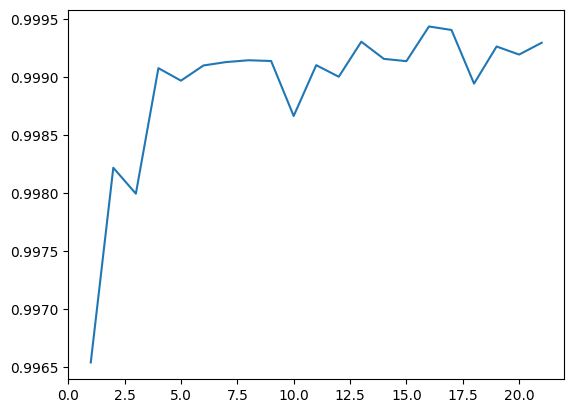

In [238]:
sns.lineplot(x=sorted_weights,y=sorted_auc_list)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


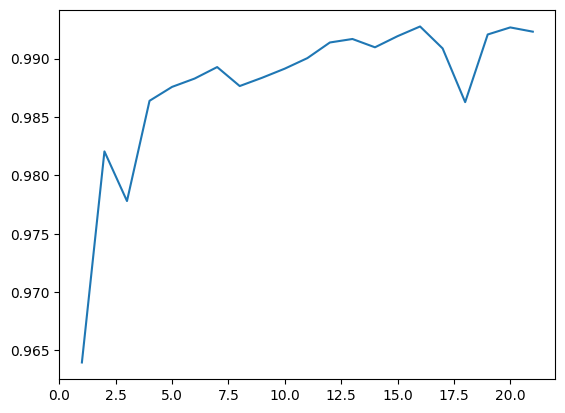

In [239]:
sns.lineplot(x=weights,y=f1_list)
plt.show()